This notebook focuses on evaluating the scores of samples generated from a Gaussian Mixture Model (GMM).

In [1]:
import sys
local_path = '../'
sys.path.append(local_path)

from utils.density_utils import gaussian_mixture_model_sampling
from utils.plot_utils import plot_real_predicted_scores

from models.models import BasicNetwork
from models.train import DenoisingScoreMatching

import numpy as np
import matplotlib.pyplot as plt

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

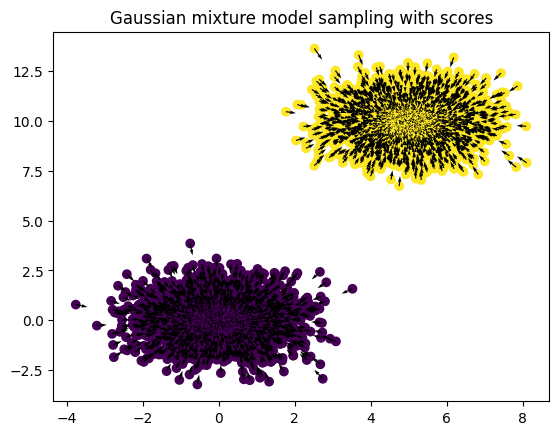

In [2]:
# Create the data (Gaussian mixture model)

# Parameters
n_samples = 5000
weights = np.array([0.5, 0.5])
means = np.array([[0., 0.], [5., 10.]])
covariances = np.array([np.eye(2), np.eye(2)])

# Generate samples
samples, cluster, scores = gaussian_mixture_model_sampling(n_samples, weights, means, covariances)

# Plot the samples and the scores
plt.figure()
plt.scatter(samples[:, 0], samples[:, 1], c=cluster)
plt.quiver(samples[:, 0], samples[:, 1], scores[:, 0], scores[:, 1])
plt.title('Gaussian mixture model sampling with scores')
plt.show()

Here, we use a basic model composed of 3 linear layers, and using ReLU function.

In [3]:
# Define the model
model = BasicNetwork().to(device)

# Parameters
lr = 1e-3
n_iter = 500
sigma = 1

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

# Train the model
list_loss = DenoisingScoreMatching(model, optimizer, sigma, device).train(samples, n_iter)
predicted_scores = model(torch.tensor(samples, dtype = torch.float32, device = device)).detach().cpu().numpy()

Denoising Score Matching:   0%|          | 0/500 [00:00<?, ?it/s]

Denoising Score Matching: 100%|██████████| 500/500 [00:01<00:00, 365.51it/s, loss=0.509]


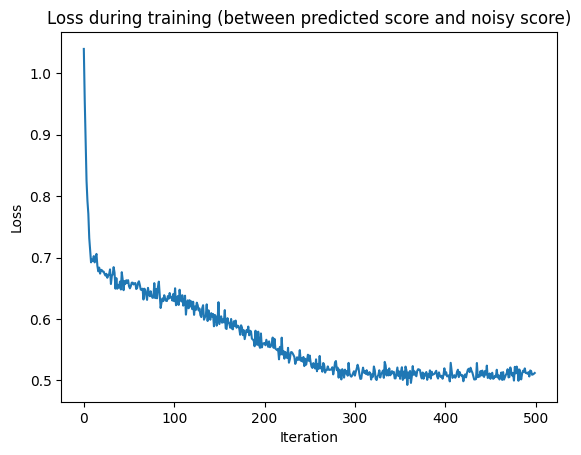

In [4]:
# Plot the loss
plt.figure()
plt.plot(list_loss)
plt.title('Loss during training (between predicted score and noisy score)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

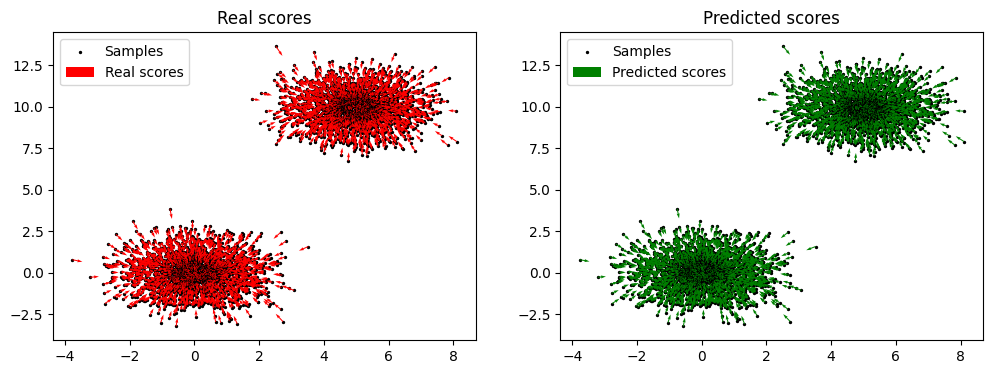

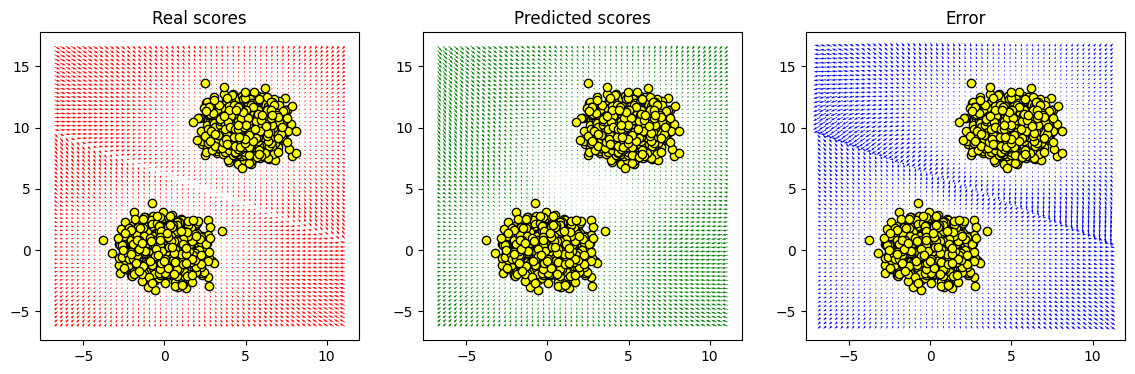

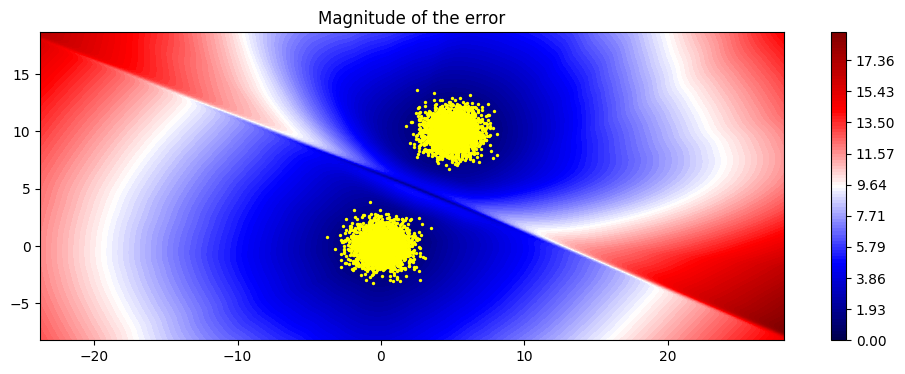

In [5]:
# Plot real score and predicted score
plot_real_predicted_scores(samples, scores, predicted_scores, model, device, weights, means, covariances)

Our model gives good predictions of the score near the means, and rather bad ones away from the means. This is because far from the means, no sample is observed, so the model cannot learn the score.